Problem statement:
Face detection is a problem in computer vision of locating and localizing one or more faces in a photograph.
Locating a face in a photograph refers to finding the coordinate of the face in the image, whereas localization refers to demarcating the extent of the face, often via a bounding box around the face.

There are perhaps two main approaches to face recognition: feature-based methods that use hand-crafted filters to search for and detect faces, and image-based methods that learn holistically how to extract faces from the entire image.

In [44]:
#install below libraries
!pip install opencv-python
!pip install mtcnn

In [45]:
#import required libraries
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
import numpy as np
import os
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [46]:
# load the pre-trained model
classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [47]:
#get images
def getimages(img_list,path):
  for (dirpath,dirnames,files)in os.walk(path):
    for file in files:
      #print(type(file))
      filepath = os.path.join(dirpath,file)
      img_list.append(filepath)
  print("Number of images at directory: ",len(img_list))
  return img_list    


In [71]:
#create bounding boxes
def draw_image_with_boxes(filename, result_list):
  data = plt.imread(filename)  
  plt.imshow(data)
  ax = plt.gca()
  for result in result_list:    
    x, y, width, height = result['box']
    rect = Rectangle((x, y), width, height, fill=False, color='White')
    ax.add_patch(rect)
    leftX=0
    leftY=0
    rightX=0
    rightY=0

    for key, value in result['keypoints'].items():
      if key=="left_eye":
        leftX=value[0]
        leftY=value[1]
      if key=="right_eye":  
        rightX=value[0]
        rightY=value[1]
      dot = Circle(value, radius=2, color='Red')
      ax.add_patch(dot)

    agg=(leftY+rightY)/2 
    foreheadY= agg-(0.3*agg)
    delta=(leftX-x)
    foreheadX=rightX+delta
    #plt.show()
    return foreheadX,foreheadY,x,y,delta,agg

In [72]:
#Forehead patch
def createPatch(fx,fy,pixels,x,y):
  return pixels[y:int(fy),x:int(fx)]


In [73]:
#Co-ordinates of this filter 
def applyfilters(img):
  fkernel=cv2.getGaborKernel((5,5),30,np.pi/8,np.pi/10,0.05,0.6,ktype=cv2.CV_32F)
  fimg=cv2.filter2D(img,cv2.CV_8UC3,fkernel)
  
  return fimg

In [74]:
#depth detection
def wrinkleMeasurements():
  pass


In [75]:
def getwrinklesCordinates(ndarr):
  data = pd.DataFrame(ndarr)
  mask = data > 0
  data = data.assign(start=mask.idxmax(axis=1), end=mask.iloc[:,::-1].idxmax(axis=1))
  data["start"] =  pd.to_numeric(data["start"])
  data["end"] =  pd.to_numeric(data["end"])
  data1 = data[(data.start != 0) & (data.end != data.shape[1]-3)]
  print(data1.shape)
  first_row = data1.index.min()
  last_row = data1.index.max()
  first_col = data1.start.min()
  last_col = data1.end.max()
  return(first_row,last_row,first_col,last_col)

In [76]:
def drawpatches(img,p,q,r,s,x,y,delta,agg):
  #data = plt.imread(img) 
  plt.imshow(img)
  ax1 = plt.gca()
  rect = Rectangle((r+x, r-p+y), s-delta, q-0.3*agg, fill=False, color='Yellow')
  ax1.add_patch(rect)


In [77]:
# create main caller
def callerfunction(detector,path):
  images=[]
  images_list=getimages(images,path)
  for filename in images_list:
    pixels = cv2.imread(filename)
    #print(pixels.shape)
    faces = detector.detect_faces(pixels)
    fx,fy,x,y,delta,agg=draw_image_with_boxes(filename, faces)
    patch=createPatch(fx,fy,pixels,x,y)
    filteredimg=applyfilters(patch)
    print("Extracted patch for forehead- ")
    cv2_imshow(patch)
    print("Detected wrinkle edges- ")
    cv2_imshow(filteredimg)
    #Supressing dimensions
    _img=filteredimg[:,:,0]
    print(_img.shape)
    p,q,r,s=getwrinklesCordinates(_img)
    #print(p,q,r,s)
    drawpatches(pixels,p,q,r,s,x,y,delta,agg)
    #print(_img[42])
    return _img

Extracted patch for forehead- 


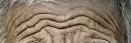

Detected wrinkle edges- 


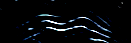

(43, 131)
(37, 133)


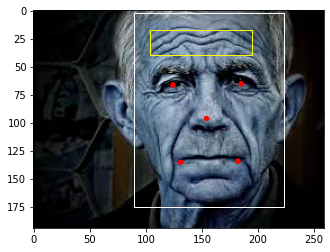

In [88]:
detector = MTCNN()
path="/content/data"
img=callerfunction(detector,path)

Depth detection :

In [79]:
imagearray=img[:,0:1]

In [14]:
tr_imagearray=imagearray.transpose()

In [15]:
tr_imagearray

array([[ 0,  0,  0,  0,  0,  0,  0,  0, 25, 21,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=uint8)

In [16]:
np.gradient(np.squeeze(imagearray))

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  12.5,  10.5,
       -12.5, -10.5,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ])

In [17]:
len(np.gradient(img,axis=(0,1)))

2

In [18]:
import pandas as pd
df0 = pd.DataFrame(np.gradient(img,axis=(0,1))[0])
df0.to_csv("data0.csv")

In [19]:
df1 = pd.DataFrame(np.gradient(img,axis=(0,1))[1])
df1.to_csv("data1.csv")

In [20]:
dfi = pd.DataFrame(img)
dfi.to_csv("img_data.csv")